In [45]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt

Reading and observing the dataset at hand

In [46]:
ls

data_description.txt  house prices.csv      regression.ipynb


In [47]:
df = pd.read_csv('house prices.csv')
df.drop('Id', inplace=True, axis=1)

In [48]:
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [50]:
def show_nans():
    nan_df = pd.DataFrame(df.isna().sum(axis=0), columns=['nan-count'])
    nan_df = nan_df.sort_values('nan-count', ascending=False)
    return nan_df

Removing Nan values if possible and replacing them with the Nan values defined specifically for each

In [51]:
df['PoolQC'].fillna('NA', inplace=True)
df['MiscFeature'].fillna('NA', inplace=True)
df['Alley'].fillna('NA', inplace=True)
df['Fence'].fillna('NA', inplace=True)
df['FireplaceQu'].fillna('NA', inplace=True)
df['GarageCond'].fillna('NA', inplace=True)
df['GarageFinish'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)
df['GarageType'].fillna('NA', inplace=True)
df['BsmtFinType2'].fillna('NA', inplace=True)
df['BsmtFinType1'].fillna('NA', inplace=True)
df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True) # should be experimented
show_nans()

,nan-count
GarageYrBlt,81
MasVnrType,8
MasVnrArea,8
Electrical,1
KitchenQual,0
...,...
ExterCond,0
ExterQual,0
Exterior2nd,0
Exterior1st,0


In [52]:
df.drop('GarageYrBlt', axis=1, inplace=True)

In [53]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [54]:
df.shape

(1451, 79)

In [55]:
number_df = df.select_dtypes('number')
object_df = df.select_dtypes('object')

In [56]:
number_df.shape, object_df.shape

((1451, 36), (1451, 43))

In [57]:
object_df.head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [58]:
number_df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500


In [59]:
for column in object_df.columns:
    object_df[column] = pd.factorize(object_df[column])[0]

<ipython-input-59-57231cb53607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_df[column] = pd.factorize(object_df[column])[0]


In [60]:
df = pd.concat([number_df, object_df], axis=1)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

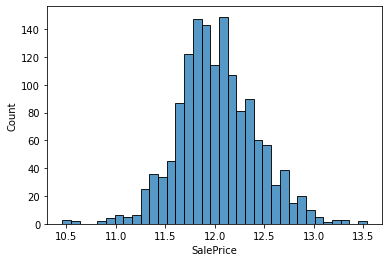

In [61]:
sns.histplot(np.log(df['SalePrice']))

Making the data loader considering the batch sizes for train and test

In [62]:
def to_dataloader(df, target_col, batch_size):
    target = torch.tensor(df[target_col].values.astype(np.float32))
    data = torch.tensor(df.drop(target_col, axis=1).values.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=batch_size)
    return data_loader

Definition of the model

In [63]:
class Regressor_nn(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, activation_function):
        super(Regressor_nn, self).__init__()
        self.activation_function = activation_function
        self.fcs = nn.ModuleList()
        self.n_layers = n_layers
        self.fcs.append(nn.Linear(input_size, hidden_size[0]))
        for i in range(n_layers - 1):
            self.fcs.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
        self.fcs.append(nn.Linear(hidden_size[-1], output_size))
    def forward(self, x):
        for i in range(n_layers):
            x = self.activation_function(self.fcs[i](x))
        x = self.fcs[-1](x)
        x = x.squeeze(1)
        return x

In [64]:
def train(model, train_loader, test_loader, criterion_mse, criterion_mae, optimizer):
    epochs_loss_mse = []
    epochs_loss_mae = []
    epochs_loss_mse_test = []
    epochs_loss_mae_test = []
    for epoch in tqdm(range(n_epochs), leave=False):
        batchs_loss_mse = []
        batchs_loss_mae = []
        for batch_idx, (data, targets) in enumerate(train_loader):
            outputs = model(data)
            mse = criterion_mse(outputs, targets)
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
            
            with torch.no_grad():
                mae = criterion_mae(outputs, targets)
            batchs_loss_mse.append(mse.item())
            batchs_loss_mae.append(mae.item())
        
        epochs_loss_mse.append(np.mean(batchs_loss_mse))
        epochs_loss_mae.append(np.mean(batchs_loss_mae))
        batchs_loss_mse_test, batchs_loss_mae_test, _, _ = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
        epochs_loss_mse_test.append(batchs_loss_mse_test)
        epochs_loss_mae_test.append(batchs_loss_mae_test)
    return epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test

In [65]:
def check_accuracy(model, loader, criterion_mse, criterion_mae):
    model.eval()
    outputs_agg = np.array([])
    targets_agg = np.array([])
    with torch.no_grad():
        batchs_loss_mse = []
        batchs_loss_mae = []
        for batch_idx, (data, targets) in enumerate(loader):
            outputs = model(data)
            outputs_agg = np.append(outputs_agg, outputs.numpy())
            targets_agg = np.append(targets_agg, targets.numpy())
            mse = criterion_mse(outputs, targets)
            mae = criterion_mae(outputs, targets)
            batchs_loss_mse.append(mse.item())     
            batchs_loss_mae.append(mae.item())
    model.train()
    return np.mean(batchs_loss_mse), np.mean(batchs_loss_mae), outputs_agg, targets_agg

In [66]:
def scaler_features(df, log_target=False):
    df_copy = df.copy()
    df_copy_target = df_copy.pop('SalePrice')
    if log_target:
        df_copy_target = np.log1p(df_copy_target)
    df_copy_target.reset_index(drop=True, inplace=True)
    scaler = MinMaxScaler()
    df_copy = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
    df_copy = pd.concat([df_copy, df_copy_target], axis=1)
    return df_copy

In [67]:
def plot_losses(epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    sns.lineplot(data=epochs_loss_mse, label='train data', ax=axs[0])
    sns.lineplot(data=epochs_loss_mse_test, label='test data', ax=axs[0])
    axs[0].grid()
    axs[0].set_title('MSE loss per epoch')
    sns.lineplot(data=epochs_loss_mae, label='train data', ax=axs[1])
    sns.lineplot(data=epochs_loss_mae_test, label='test data', ax=axs[1])
    axs[1].grid()
    axs[1].set_title('MAE loss per epoch')
    plt.tight_layout()

In [68]:
def plot_predictions(outputs_agg, targets_agg):
    fig = plt.figure(figsize=(10, 10))
    sns.scatterplot(y=outputs_agg, x=targets_agg)
    plt.ylabel('predictions')
    plt.xlabel('targets')

In [69]:
batch_size = 64
dff = scaler_features(df, log_target=True)
train_df = dff.sample(frac=.8, random_state=707)
test_df = dff.drop(train_df.index)

train_loader = to_dataloader(
    df=train_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)
test_loader = to_dataloader(
    df=test_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)

In [70]:
input_size = df.shape[1] - 1
n_layers = 4
hidden_size = [100, 64, 32, 16]
activation_function = F.relu
output_size = 1
lr = 0.001
n_epochs = 200

  0%|          | 0/200 [00:00<?, ?it/s]

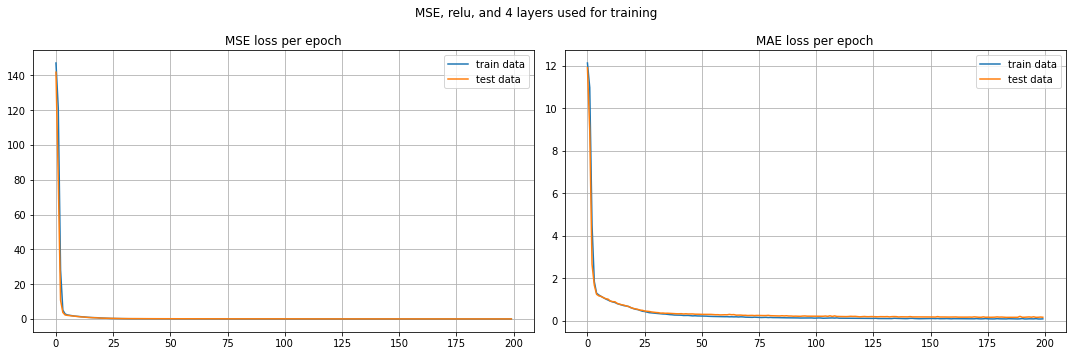

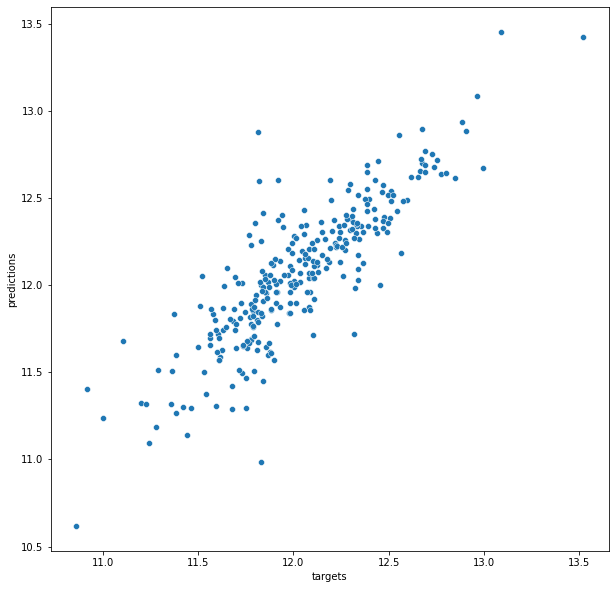

In [72]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[1], str(len(hidden_size)))
)
_, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
plot_predictions(outputs_agg, targets_agg)

  0%|          | 0/200 [00:00<?, ?it/s]

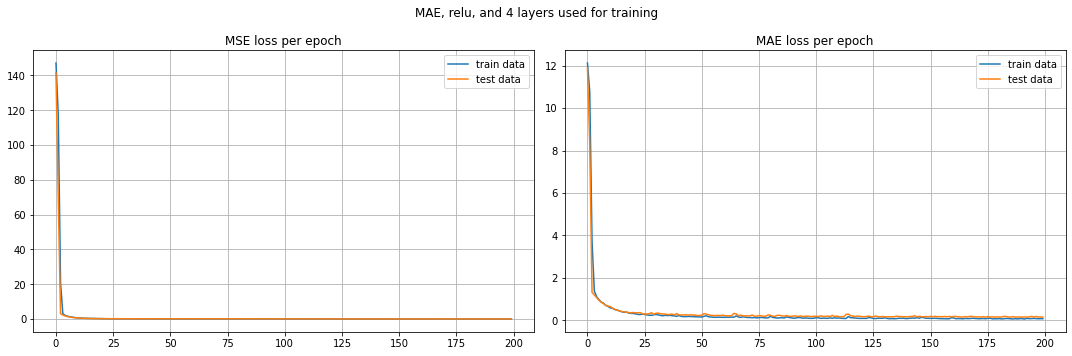

In [73]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mae, epochs_loss_mse, epochs_loss_mae_test, epochs_loss_mse_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mae,
    criterion_mse,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MAE, {}, and {} layers used for training'.format(str(activation_function).split()[1], str(len(hidden_size)))
)

In [74]:
batch_size = 32
input_size = df.shape[1] - 1
n_layers = 4
hidden_size = [100, 64, 32, 16]
activation_function = torch.sigmoid
output_size = 1
lr = 0.001
n_epochs = 150

  0%|          | 0/150 [00:00<?, ?it/s]

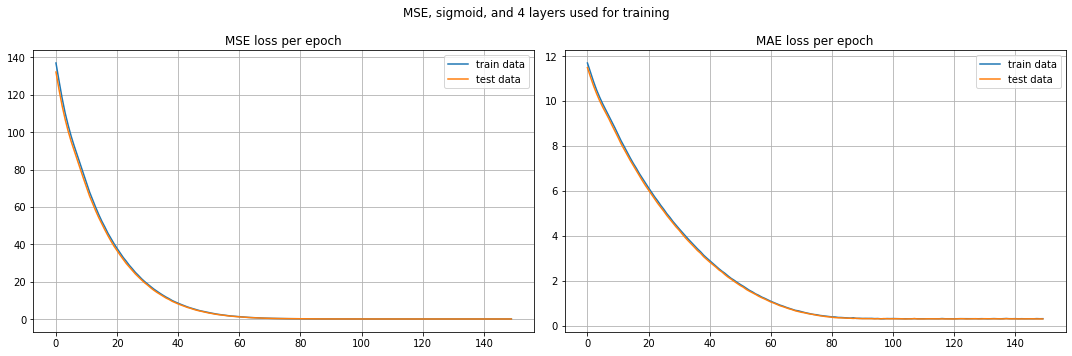

In [75]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[2], str(len(hidden_size)))
)

In [76]:
batch_size = 64
input_size = df.shape[1] - 1
n_layers = 2
hidden_size = [100, 64]
activation_function = F.relu
output_size = 1
lr = 0.001
n_epochs = 150

  0%|          | 0/150 [00:00<?, ?it/s]

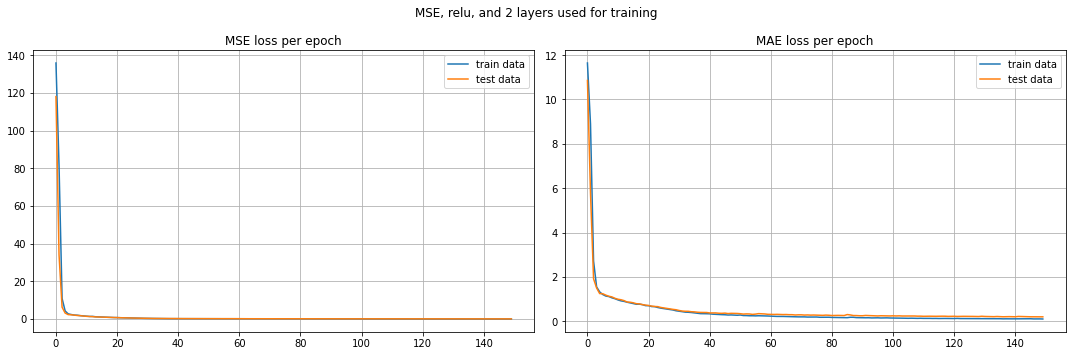

In [77]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[1], str(len(hidden_size)))
)

In [78]:
batch_size = 64
input_size = df.shape[1] - 1
n_layers = 2
hidden_size = [100, 64]
activation_function = torch.sigmoid
output_size = 1
lr = 0.001
n_epochs = 150

  0%|          | 0/150 [00:00<?, ?it/s]

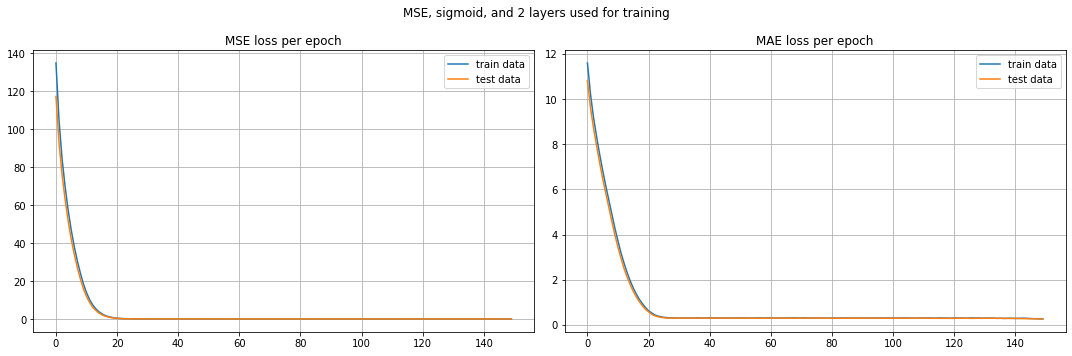

In [79]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[2], str(len(hidden_size)))
)